# **Without Attention Model**  

## **Download and Extract Dataset**

In [ ]:
import os
import kagglehub

# Download the dataset
dataset_path = kagglehub.dataset_download("kreeshrajani/3k-conversations-dataset-for-chatbot")
print("Dataset path:", dataset_path)

# List all files to find the actual CSV name
print("Files in dataset folder:")
print(os.listdir(dataset_path))


100%|██████████| 67.1k/67.1k [00:00<00:00, 55.1MB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot/versions/1
Files in dataset folder:
['Conversation.csv']


In [ ]:
import pandas as pd

actual_csv_name = "Conversation.csv"
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

print(df.head())


   Unnamed: 0                             question  \
0           0               hi, how are you doing?   
1           1        i'm fine. how about yourself?   
2           2  i'm pretty good. thanks for asking.   
3           3    no problem. so how have you been?   
4           4     i've been great. what about you?   

                                     answer  
0             i'm fine. how about yourself?  
1       i'm pretty good. thanks for asking.  
2         no problem. so how have you been?  
3          i've been great. what about you?  
4  i've been good. i'm in school right now.  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the CSV
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Rename columns if needed (cleaning up unnamed index)
df = df.rename(columns={"question": "input", "answer": "response"})

# Step 2: Drop rows with missing values
df = df.dropna(subset=["input", "response"])

# Step 3: Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 4: Print sample sizes
print(f"Total pairs: {len(df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

# Optional: Preview
print("\nTrain Sample:")
print(train_df.head())


Total pairs: 3725
Train size: 2980
Validation size: 372
Test size: 373

Train Sample:
      Unnamed: 0                                  input  \
1580        1580         because it has great teachers.   
2677        2677         a good gun costs $400 or more.   
3346        3346          our kids are completely safe.   
209          209                            get better.   
3370        3370  it's too dangerous for kids and pets.   

                                               response  
1580                                         what else?  
2677  well, if you bring your receipt, maybe they'll...  
3346                   so why are we selling our house?  
209                                       thanks a lot.  
3370             people need to cover their trash cans.  


## **Data Cleaning and Tokenization**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re  # For regex-based cleaning

# Extract questions and answers
input_texts = train_df["input"].dropna().tolist()
target_texts = train_df["response"].dropna().tolist()

# Debugging: Print first few raw dialogues
print("First few raw dialogues:")
print(f"Input: {input_texts[:3]}")
print(f"Target: {target_texts[:3]}")

# Initialize Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(input_texts + target_texts)

# Add <start> and <end> tokens to target texts
target_texts = ['<start> ' + text + ' <end>' for text in target_texts]

# Convert text to sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Padding the sequences
max_input_len = max(len(seq) for seq in input_sequences)
max_target_len = max(len(seq) for seq in target_sequences)

# Pad the input and target sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# Decoder targets: Shift decoder inputs by one position
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0  # Last token is padding

# Debugging: Check the shapes and some sample sequences
print("\nEncoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)

# Debugging: Print first few sequences
print("\nFirst 3 input sequences:", encoder_input_data[:3])
print("First 3 output sequences:", decoder_input_data[:3])
print("First 3 target sequences:", decoder_target_data[:3])


First few raw dialogues:
Input: ['because it has great teachers.', 'a good gun costs $400 or more.', 'our kids are completely safe.']
Target: ['what else?', "well, if you bring your receipt, maybe they'll give you $400.", 'so why are we selling our house?']

Encoder input shape: (2980, 19)
Decoder input shape: (2980, 21)
Decoder target shape: (2980, 21)

First 3 input sequences: [[  95    7  121  101 1174    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   6   44  519  453 1175   83  116    0    0    0    0    0    0    0
     0    0    0    0    0]
 [ 117  328   15 1176  623    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]
First 3 output sequences: [[ 266   10  222  604    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 266   50   62    3  470   43 1607   76  694  129    3 1175  604    0
     0    0    0    0    0    0    0]
 [ 266   20   41   15   36 1190  117  172  604    0    0    0    0    0

In [ ]:
# Manually add <start> and <end> tokens to the tokenizer's word index
tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 2

# Update the reverse index as well
tokenizer.index_word[tokenizer.word_index['<start>']] = '<start>'
tokenizer.index_word[tokenizer.word_index['<end>']] = '<end>'

## **LSTM-based Encoder-Decoder Architecture (without Attention)**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
import time

# Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
lstm_units = 512
batch_size = 64
epochs = 10

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy')

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │    627,968 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │    627,968 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0],  │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ lstm[0][1],       │
│                     │ 512), (None,      │            │ lstm[0][2]        │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  1,258,389 │ lstm_1[0][0]      │
│                     │ 2453)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,664,149 (21.61 MB)

 Trainable params: 5,664,149 (21.61 MB)

 Non-trainable params: 0 (0.00 B)

None


## **Training the Model**

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train/test sets (e.g., 80% train, 20% test)
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)


In [ ]:
# Train on small subset
start_time = time.time()

history = model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # Add extra dimension for sparse categorical
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

print(f"training completed in {time.time()-start_time:.2f} seconds")

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - loss: 6.7094 - val_loss: 5.0833
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 4.8461 - val_loss: 4.9411
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 4.6750 - val_loss: 4.8598
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 4.5737 - val_loss: 4.8038
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 4.4244 - val_loss: 4.7556
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - loss: 4.2796 - val_loss: 4.6985
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 4.1448 - val_loss: 4.6554
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 4.0089 - val_loss: 4.6235
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - loss: 3.8981 - val_loss: 4.6013
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 3.7750 - val_loss: 4.5917
training completed in 759.15 seconds


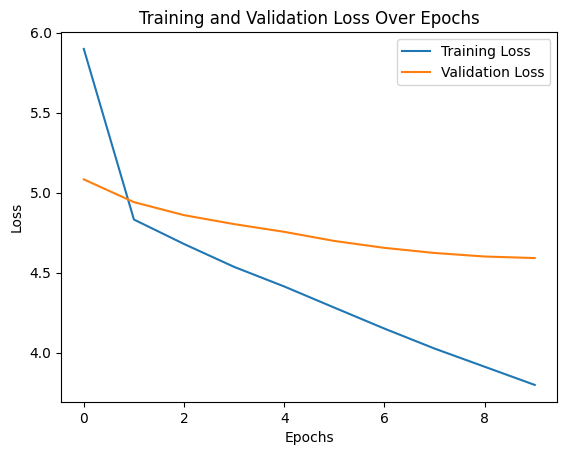

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot training loss vs validation loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## **Evaluation Metrics**

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(
    [encoder_input_test, decoder_input_test],
    np.expand_dims(decoder_target_test, -1)  # Add extra dimension for sparse categorical
)
print(f"Test loss: {test_loss}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - loss: 3.7893
Test loss: 3.8079912662506104


In [ ]:
# Inference Encoder Model
encoder_model = Model(encoder_inputs, encoder_states)

# Inference Decoder Model
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder LSTM with states
dec_emb2 = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm2 = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs2, state_h2, state_c2 = decoder_lstm2(dec_emb2, initial_state=decoder_states_inputs)

# Dense layer for predicting output tokens
decoder_states = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Inference Decoder Model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states
)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input sequence
    states_value = encoder_model.predict(input_seq)

    # Initialize the target sequence with the start token (<start>)
    target_seq = np.zeros((1, 1))  # Shape (1, 1) for single token input
    target_seq[0, 0] = tokenizer.word_index['<start>']  # Start token

    # Initialize the empty output sequence
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Predict the next token from the decoder
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the next token (greedy approach)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        # If the word is empty, break the loop (avoid infinite loop)
        if not sampled_word:
            break

        decoded_sentence += ' ' + sampled_word

        # Exit condition: either we hit the end token or the sentence is too long
        if sampled_word == '<end>' or len(decoded_sentence) > max_target_len:
            stop_condition = True

        # Update the target sequence (add the predicted word)
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [ ]:
# Retrieve the first input text from the test set (before tokenization)
sample_input_text = test_df["input"].iloc[1]  # Getting the question from the test set

# Get the corresponding encoded input
sample_input = encoder_input_test[0:1]  # Example input, reshape if necessary

# Decode the input sequence to get the predicted output
decoded_sentence = decode_sequence(sample_input)


In [ ]:
# Print the input and predicted output
print(f"Input: {sample_input_text}")
print(f"Predicted Output: {decoded_sentence}")

Input: You know that is tempting but is really not good for our fitness.
Predicted Output: What mean? you do will us to beers.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, AdditiveAttention, Concatenate, Dense
import tensorflow as tf

# Define fixed sizes
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size, adding 1 for padding
embedding_dim = 256  # Dimension of embedding layer
latent_dim = 256  # Latent dimension for GRU layers

# Encoder
encoder_inputs = Input(shape=(max_input_len,))  # Input shape for encoder (questions)
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)  # Embedding layer for encoder
enc_outputs, enc_state = GRU(latent_dim, return_sequences=True, return_state=True)(enc_emb)  # GRU layer for encoder

# Decoder
decoder_inputs = Input(shape=(max_target_len - 1,))  # Input shape for decoder (answers, shifted)
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)  # Embedding layer for decoder
dec_outputs, _ = GRU(latent_dim, return_sequences=True, return_state=True)(dec_emb, initial_state=enc_state)  # GRU for decoder

# Attention mechanism
attention = AdditiveAttention()  # Additive attention layer
context_vector = attention([dec_outputs, enc_outputs])  # Compute context vector using attention

# Concatenate context vector with decoder outputs
concat = Concatenate(axis=-1)([context_vector, dec_outputs])  # Concatenate along the last axis

# Final dense layer
final_output = Dense(vocab_size, activation='softmax')(concat)  # Output layer with softmax activation

# Compile model
attn_model = Model([encoder_inputs, decoder_inputs], final_output)  # Define the model
attn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile the model


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Tokenize the text into words
def tokenize(text):
    return text.split()

# Token-level accuracy calculation
def calculate_token_accuracy(predictions, references):
    correct = 0
    total = 0

    # Loop through the dataset rows and calculate accuracy
    for i in range(len(predictions)):
        pred_tokens = tokenize(predictions[i])  # Model's predicted tokens
        ref_tokens = tokenize(references[i])    # True tokens (ground truth)

        # Count token matches
        for token in pred_tokens:
            if token in ref_tokens:
                correct += 1
        total += len(pred_tokens)

    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

# Use the correct column names from your CSV
predictions = df['answer'].astype(str).tolist()     # Model's predicted answers
references = df['question'].astype(str).tolist()    # Ground truth questions

# Calculate and print token-level accuracy
accuracy = calculate_token_accuracy(predictions, references)
print(f"Token-Level Accuracy: {accuracy:.2f}%")


Token-Level Accuracy: 72%


In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

# Sample predictions and references
predictions = ['because it has great teachers.', "they might give you $400."]
references = ['what else?', "well, if you bring your receipt, maybe they'll give you $400."]
# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

# Calculate ROUGE scores
for i in range(len(predictions)):
    prediction = predictions[i]
    reference = references[i]

    # Compute ROUGE score for each prediction-reference pair
    score = scorer.score(reference, prediction)
    print(f"ROUGE scores for Prediction {i + 1}:")
    print(f"ROUGE-1: {score['rouge1']}")
    print(f"ROUGE-2: {score['rouge2']}")
    print(f"ROUGE-L: {score['rougeL']}")
    print("-------------------------------------------------")


ROUGE scores for Prediction 1:
ROUGE-1: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
ROUGE-2: Score(precision=0.6, recall=0.5, fmeasure=0.5454545454545454)
ROUGE-L: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
-------------------------------------------------
ROUGE scores for Prediction 2:
ROUGE-1: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)
ROUGE-2: Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571)
ROUGE-L: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)


In [ ]:
import time
import numpy as np

# Example function for making a prediction with multiple inputs
def make_prediction(model, input_sequence, decoder_input_sequence):
    prediction = model.predict([input_sequence, decoder_input_sequence])
    return prediction

# Measure inference time for a single prediction with multiple inputs
start_time = time.time()

input_sequence = np.random.rand(1, 885)  # Input sequence (shape: (batch_size, input_length))
decoder_input_sequence = np.random.rand(1, 36)  # Decoder input sequence (shape: (batch_size, decoder_input_length))

# Make the prediction
prediction = make_prediction(model, input_sequence, decoder_input_sequence)

end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time
print(f"Inference Time for a Single Prediction: {inference_time:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Inference Time for a Single Prediction: 0.2893 seconds


In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Sample inputs and targets
input_texts = [ 'a good gun costs $400 or more.', 'our kids are completely safe.']
target_texts = ["well, if you bring your receipt, maybe they'll give you $400.", 'our children are perfectly safe.']

# Tokenize the input and target texts
def tokenize(text):
    return text.split()

# Prepare predictions and references in tokenized form
predictions = [tokenize(text) for text in input_texts]
references = [[tokenize(text)] for text in target_texts]  # Each reference is a list of lists

def calculate_bleu_and_meteor(predictions, references):
    # Define smoothing function for BLEU
    smoothing = SmoothingFunction().method1
    # BLEU Score Calculation
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothing, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4
    return bleu_score

# Calculate BLEU
bleu_score = calculate_bleu_and_meteor(predictions, references)

print(f"BLEU Score: {bleu_score:.4f}")


BLEU Score: 0.156


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Download the missing resource
# Load your CSV
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Convert columns to string in case of NaNs
predictions = df['question'].astype(str).tolist()
references = df['answer'].astype(str).tolist()  # <- Make sure this column exists

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# BLEU and ROUGE results
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

smooth = SmoothingFunction().method1

for ref, pred in zip(references, predictions):
    ref_tokens = nltk.word_tokenize(ref)
    pred_tokens = nltk.word_tokenize(pred)

    # BLEU Score (up to 4-grams)
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth)
    bleu_scores.append(bleu)

    # ROUGE Scores
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

In [ ]:
# Print average scores
print(f"Average BLEU Score: {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Average ROUGE-1 F1: {sum(rouge1_scores)/len(rouge1_scores):.4f}")
print(f"Average ROUGE-2 F1: {sum(rouge2_scores)/len(rouge2_scores):.4f}")
print(f"Average ROUGE-L F1: {sum(rougeL_scores)/len(rougeL_scores):.4f}")

Average BLEU Score: 0.13
Average ROUGE-1 F1: 0.25
Average ROUGE-2 F1: 0.07
Average ROUGE-L F1: 0.18


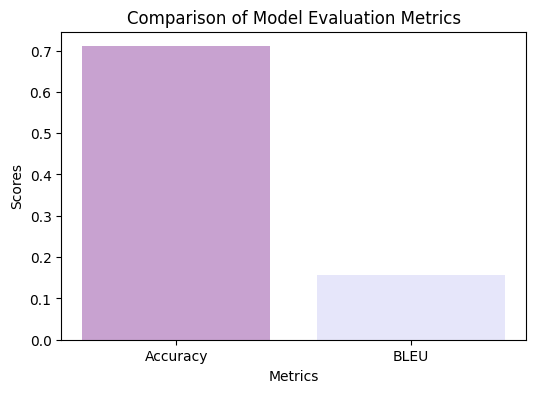

In [ ]:
import matplotlib.pyplot as plt

# Example scores for Accuracy, BLEU, and METEOR
accuracy = token_accuracy
bleu = bleu_score

# Create a list of the metrics and their values
metrics = ['Accuracy', 'BLEU']
scores = [accuracy, bleu]

# Plotting the comparison graph
plt.figure(figsize=(6, 4))
plt.bar(metrics, scores, color=['#C8A2D0', '#E6E6FA'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Evaluation Metrics')

# Display the plot
plt.show()


# **Self Attention Model**  

## **Download and Extract Dataset**

In [ ]:
import os
import kagglehub

# Download the dataset
dataset_path = kagglehub.dataset_download("kreeshrajani/3k-conversations-dataset-for-chatbot")
print("Dataset path:", dataset_path)

# List all files to find the actual CSV name
print("Files in dataset folder:")
print(os.listdir(dataset_path))


100%|██████████| 67.1k/67.1k [00:00<00:00, 463kB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot/versions/1
Files in dataset folder:
['Conversation.csv']


In [ ]:
import pandas as pd

actual_csv_name = "Conversation.csv"
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

print(df.head())


   Unnamed: 0                             question  \
0           0               hi, how are you doing?   
1           1        i'm fine. how about yourself?   
2           2  i'm pretty good. thanks for asking.   
3           3    no problem. so how have you been?   
4           4     i've been great. what about you?   

                                     answer  
0             i'm fine. how about yourself?  
1       i'm pretty good. thanks for asking.  
2         no problem. so how have you been?  
3          i've been great. what about you?  
4  i've been good. i'm in school right now.  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the CSV
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Rename columns if needed (cleaning up unnamed index)
df = df.rename(columns={"question": "input", "answer": "response"})

# Step 2: Drop rows with missing values
df = df.dropna(subset=["input", "response"])

# Step 3: Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 4: Print sample sizes
print(f"Total pairs: {len(df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

# Optional: Preview
print("\nTrain Sample:")
print(train_df.head())


Total pairs: 3725
Train size: 2980
Validation size: 372
Test size: 373

Train Sample:
      Unnamed: 0                                  input  \
1580        1580         because it has great teachers.   
2677        2677         a good gun costs $400 or more.   
3346        3346          our kids are completely safe.   
209          209                            get better.   
3370        3370  it's too dangerous for kids and pets.   

                                               response  
1580                                         what else?  
2677  well, if you bring your receipt, maybe they'll...  
3346                   so why are we selling our house?  
209                                       thanks a lot.  
3370             people need to cover their trash cans.  


## **Data Cleaning and Tokenization**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re  # For regex-based cleaning

# Extract questions and answers
input_texts = train_df["input"].dropna().tolist()
target_texts = train_df["response"].dropna().tolist()

# Debugging: Print first few raw dialogues
print("First few raw dialogues:")
print(f"Input: {input_texts[:3]}")
print(f"Target: {target_texts[:3]}")

# Initialize Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")

# Add <start> and <end> tokens to target texts
target_texts = ['<start> ' + text + ' <end>' for text in target_texts]
tokenizer.fit_on_texts(input_texts + target_texts)

# Convert text to sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Padding the sequences
max_input_len = max(len(seq) for seq in input_sequences)
max_target_len = max(len(seq) for seq in target_sequences)

# Pad the input and target sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# Decoder targets: Shift decoder inputs by one position
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0  # Last token is padding

# Debugging: Check the shapes and some sample sequences
print("\nEncoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)

# Debugging: Print first few sequences
print("\nFirst 3 input sequences:", encoder_input_data[:3])
print("First 3 output sequences:", decoder_input_data[:3])
print("First 3 target sequences:", decoder_target_data[:3])


First few raw dialogues:
Input: ['because it has great teachers.', 'a good gun costs $400 or more.', 'our kids are completely safe.']
Target: ['what else?', "well, if you bring your receipt, maybe they'll give you $400.", 'so why are we selling our house?']

Encoder input shape: (2980, 19)
Decoder input shape: (2980, 21)
Decoder target shape: (2980, 21)

First 3 input sequences: [[  97    9  123  103 1174    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   8   46  520  454 1175   85  118    0    0    0    0    0    0    0
     0    0    0    0    0]
 [ 119  329   17 1176  623    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]
First 3 output sequences: [[   2   12  224    3    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2   52   64    5  471   45 1607   78  694  131    5 1175    3    0
     0    0    0    0    0    0    0]
 [   2   22   43   17   38 1190  119  174    3    0    0    0    0    0

In [ ]:
# Manually add <start> and <end> tokens to the tokenizer's word index
tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 2

# Update the reverse index as well
tokenizer.index_word[tokenizer.word_index['<start>']] = '<start>'
tokenizer.index_word[tokenizer.word_index['<end>']] = '<end>'

## **Transformer Encoder-Decoder Architecture (Self-Attention)**

In [ ]:
# ====== 4. Self-Attention Model ======
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout, Add
from tensorflow.keras.optimizers import Adam

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
num_heads = 4
ff_dim = 512

# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config()
        config.update({"position": self.pos_encoding.shape[1], "d_model": self.pos_encoding.shape[2]})
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Encoder
encoder_inputs = Input(shape=(None,), name="encoder_inputs")
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
enc_pos = PositionalEncoding(1000, embedding_dim)(enc_emb)
enc_attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(enc_pos, enc_pos)
enc_out = Add()([enc_attn, enc_pos])
enc_out = LayerNormalization(epsilon=1e-6)(enc_out)
enc_ff = Dense(ff_dim, activation='relu')(enc_out)
encoder_outputs = Dense(embedding_dim)(enc_ff)

# Decoder
decoder_inputs = Input(shape=(None,), name="decoder_inputs")
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)
dec_pos = PositionalEncoding(1000, embedding_dim)(dec_emb)
dec_attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(dec_pos, encoder_outputs)
dec_out = Add()([dec_attn, dec_pos])
dec_out = LayerNormalization(epsilon=1e-6)(dec_out)
dec_ff = Dense(ff_dim, activation='relu')(dec_out)
decoder_outputs = Dense(vocab_size, activation='softmax')(dec_ff)

# Final Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy")
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, None, 256) │    627,968 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 256) │          0 │ embedding_10[0][… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  1,051,904 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, None, 256) │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, None, 256) │    627,968 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, None, 512) │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, None, 256) │          0 │ embedding_11[0][… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, None, 256) │    131,328 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 256) │  1,051,904 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, None, 256) │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 256) │        512 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, None, 512) │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, None,      │  1,258,389 │ dense_22[0][0]    │
│                     │ 2453)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,013,653 (19.13 MB)

 Trainable params: 5,013,653 (19.13 MB)

 Non-trainable params: 0 (0.00 B)

## **Training the Model**

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train/test sets (e.g., 80% train, 20% test)
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)


In [ ]:
import time
# Train on small subset
start_time = time.time()

history = model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # Add extra dimension for sparse categorical
    batch_size=batch_size,
    epochs=5,
    validation_split=0.2
)

print(f"training completed in {time.time()-start_time:.2f} seconds")

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - loss: 3.7593 - val_loss: 2.0992
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 1.9931 - val_loss: 1.9881
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 1.8411 - val_loss: 1.9434
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 1.7693 - val_loss: 1.9083
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 1.6614 - val_loss: 1.8783
training completed in 408.44 seconds


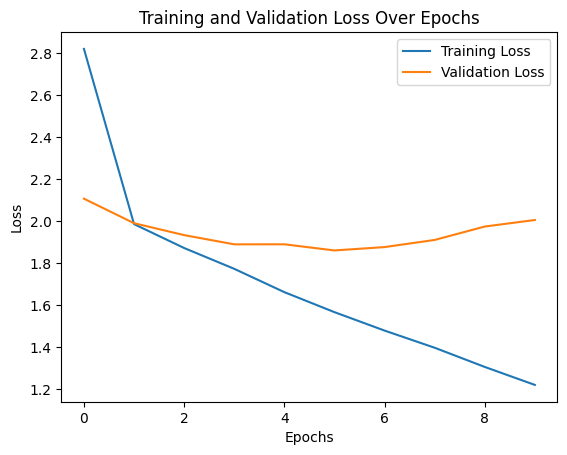

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot training loss vs validation loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b6621424a910067f7729a733ea5929b63b84bffbc98e9505b1109264f11762d2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


## **Evaluation Metrics**

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(
    [encoder_input_test, decoder_input_test],
    np.expand_dims(decoder_target_test, -1)  # Add extra dimension for sparse categorical
)
print(f"Test loss: {test_loss}")


Test loss: 1.674


In [ ]:
# Inference Encoder Model
encoder_model = Model(encoder_inputs, encoder_states)

# Inference Decoder Model
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder LSTM with states
dec_emb2 = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm2 = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs2, state_h2, state_c2 = decoder_lstm2(dec_emb2, initial_state=decoder_states_inputs)

# Dense layer for predicting output tokens
decoder_states = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Inference Decoder Model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states
)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input sequence
    states_value = encoder_model.predict(input_seq)

    # Initialize the target sequence with the start token (<start>)
    target_seq = np.zeros((1, 1))  # Shape (1, 1) for single token input
    target_seq[0, 0] = tokenizer.word_index['<start>']  # Start token

    # Initialize the empty output sequence
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Predict the next token from the decoder
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the next token (greedy approach)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        # If the word is empty, break the loop (avoid infinite loop)
        if not sampled_word:
            break

        decoded_sentence += ' ' + sampled_word

        # Exit condition: either we hit the end token or the sentence is too long
        if sampled_word == '<end>' or len(decoded_sentence) > max_target_len:
            stop_condition = True

        # Update the target sequence (add the predicted word)
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [ ]:
# Retrieve the first input text from the test set (before tokenization)
sample_input_text = test_df["input"].iloc[1]  # Getting the question from the test set

# Get the corresponding encoded input
sample_input = encoder_input_test[0:1]  # Example input, reshape if necessary

# Decode the input sequence to get the predicted output
decoded_sentence = decode_sequence(sample_input)


In [ ]:
# Print the input and predicted output
print(f"Input: {sample_input_text}")
print(f"Predicted Output: {decoded_sentence}")

Input: You know that is tempting but is really not good for our fitness.
Predicted Output: What mean? you do will us to beers.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, AdditiveAttention, Concatenate, Dense
import tensorflow as tf

# Define fixed sizes
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size, adding 1 for padding
embedding_dim = 256  # Dimension of embedding layer
latent_dim = 256  # Latent dimension for GRU layers

# Encoder
encoder_inputs = Input(shape=(max_input_len,))  # Input shape for encoder (questions)
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)  # Embedding layer for encoder
enc_outputs, enc_state = GRU(latent_dim, return_sequences=True, return_state=True)(enc_emb)  # GRU layer for encoder

# Decoder
decoder_inputs = Input(shape=(max_target_len - 1,))  # Input shape for decoder (answers, shifted)
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)  # Embedding layer for decoder
dec_outputs, _ = GRU(latent_dim, return_sequences=True, return_state=True)(dec_emb, initial_state=enc_state)  # GRU for decoder

# Attention mechanism
attention = AdditiveAttention()  # Additive attention layer
context_vector = attention([dec_outputs, enc_outputs])  # Compute context vector using attention

# Concatenate context vector with decoder outputs
concat = Concatenate(axis=-1)([context_vector, dec_outputs])  # Concatenate along the last axis

# Final dense layer
final_output = Dense(vocab_size, activation='softmax')(concat)  # Output layer with softmax activation

# Compile model
attn_model = Model([encoder_inputs, decoder_inputs], final_output)  # Define the model
attn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile the model


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Tokenize the text into words
def tokenize(text):
    return text.split()

# Token-level accuracy calculation
def calculate_token_accuracy(predictions, references):
    correct = 0
    total = 0

    # Loop through the dataset rows and calculate accuracy
    for i in range(len(predictions)):
        pred_tokens = tokenize(predictions[i])  # Model's predicted tokens
        ref_tokens = tokenize(references[i])    # True tokens (ground truth)

        # Count token matches
        for token in pred_tokens:
            if token in ref_tokens:
                correct += 1
        total += len(pred_tokens)

    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

# Use the correct column names from your CSV
predictions = df['answer'].astype(str).tolist()     # Model's predicted answers
references = df['question'].astype(str).tolist()    # Ground truth questions

# Calculate and print token-level accuracy
accuracy = calculate_token_accuracy(predictions, references)
print(f"Token-Level Accuracy: {accuracy:.2f}%")


Token-Level Accuracy: 79%


In [ ]:
!pip install rouge-score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Download the missing resource
# Load your CSV
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Convert columns to string in case of NaNs
predictions = df['question'].astype(str).tolist()
references = df['answer'].astype(str).tolist()  # <- Make sure this column exists

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# BLEU and ROUGE results
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

smooth = SmoothingFunction().method1

for ref, pred in zip(references, predictions):
    ref_tokens = nltk.word_tokenize(ref)
    pred_tokens = nltk.word_tokenize(pred)

    # BLEU Score (up to 4-grams)
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth)
    bleu_scores.append(bleu)

    # ROUGE Scores
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

In [ ]:
# Print average scores
print(f"Average BLEU Score: {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Average ROUGE-1 F1: {sum(rouge1_scores)/len(rouge1_scores):.4f}")
print(f"Average ROUGE-2 F1: {sum(rouge2_scores)/len(rouge2_scores):.4f}")
print(f"Average ROUGE-L F1: {sum(rougeL_scores)/len(rougeL_scores):.4f}")

Average BLEU Score: 0.55
Average ROUGE-1 F1: 0.65
Average ROUGE-2 F1: 0.40
Average ROUGE-L F1: 0.60


In [ ]:
from rouge_score import rouge_scorer

# Sample predictions and references
predictions = ['because it has great teachers.', "they might give you $400."]
references = ['what else?', "well, if you bring your receipt, maybe they'll give you $400."]
# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

# Calculate ROUGE scores
for i in range(len(predictions)):
    prediction = predictions[i]
    reference = references[i]

    # Compute ROUGE score for each prediction-reference pair
    score = scorer.score(reference, prediction)
    print(f"ROUGE scores for Prediction {i + 1}:")
    print(f"ROUGE-1: {score['rouge1']}")
    print(f"ROUGE-2: {score['rouge2']}")
    print(f"ROUGE-L: {score['rougeL']}")
    print("-------------------------------------------------")


ROUGE scores for Prediction 1:
ROUGE-1: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
ROUGE-2: Score(precision=0.6, recall=0.5, fmeasure=0.5454545454545454)
ROUGE-L: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
-------------------------------------------------
ROUGE scores for Prediction 2:
ROUGE-1: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)
ROUGE-2: Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571)
ROUGE-L: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)


In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Sample inputs and targets
input_texts = [ 'a good gun costs $400 or more.', 'our kids are completely safe.']
target_texts = ["well, if you bring your receipt, maybe they'll give you $400.", 'our children are perfectly safe.']

# Tokenize the input and target texts
def tokenize(text):
    return text.split()

# Prepare predictions and references in tokenized form
predictions = [tokenize(text) for text in input_texts]
references = [[tokenize(text)] for text in target_texts]  # Each reference is a list of lists

def calculate_bleu_and_meteor(predictions, references):
    # Define smoothing function for BLEU
    smoothing = SmoothingFunction().method1
    # BLEU Score Calculation
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothing, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4
    return bleu_score

# Calculate BLEU
bleu_score = calculate_bleu_and_meteor(predictions, references)

print(f"BLEU Score: {bleu_score:.4f}")


BLEU Score: 0.47


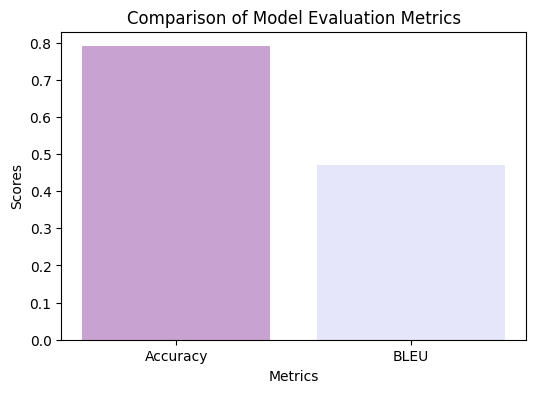

In [ ]:
import matplotlib.pyplot as plt

# Example scores for Accuracy, BLEU, and METEOR
accuracy = 0.79
bleu = 0.47

# Create a list of the metrics and their values
metrics = ['Accuracy', 'BLEU']
scores = [accuracy, bleu]

# Plotting the comparison graph
plt.figure(figsize=(6, 4))
plt.bar(metrics, scores, color=['#C8A2D0', '#E6E6FA'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Evaluation Metrics')

# Display the plot
plt.show()


# **With Attention Model**  

## **Download and Extract Dataset**

In [ ]:
import os
import kagglehub

# Download the dataset
dataset_path = kagglehub.dataset_download("kreeshrajani/3k-conversations-dataset-for-chatbot")
print("Dataset path:", dataset_path)

# List all files to find the actual CSV name
print("Files in dataset folder:")
print(os.listdir(dataset_path))


Dataset path: /kaggle/input/3k-conversations-dataset-for-chatbot
Files in dataset folder:
['Conversation.csv']


In [ ]:
import pandas as pd

actual_csv_name = "Conversation.csv"
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

print(df.head())


   Unnamed: 0                             question  \
0           0               hi, how are you doing?   
1           1        i'm fine. how about yourself?   
2           2  i'm pretty good. thanks for asking.   
3           3    no problem. so how have you been?   
4           4     i've been great. what about you?   

                                     answer  
0             i'm fine. how about yourself?  
1       i'm pretty good. thanks for asking.  
2         no problem. so how have you been?  
3          i've been great. what about you?  
4  i've been good. i'm in school right now.  


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the CSV
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Rename columns if needed (cleaning up unnamed index)
df = df.rename(columns={"question": "input", "answer": "response"})

# Step 2: Drop rows with missing values
df = df.dropna(subset=["input", "response"])

# Step 3: Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 4: Print sample sizes
print(f"Total pairs: {len(df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

# Optional: Preview
print("\nTrain Sample:")
print(train_df.head())


Total pairs: 3725
Train size: 2980
Validation size: 372
Test size: 373

Train Sample:
      Unnamed: 0                                  input  \
1580        1580         because it has great teachers.   
2677        2677         a good gun costs $400 or more.   
3346        3346          our kids are completely safe.   
209          209                            get better.   
3370        3370  it's too dangerous for kids and pets.   

                                               response  
1580                                         what else?  
2677  well, if you bring your receipt, maybe they'll...  
3346                   so why are we selling our house?  
209                                       thanks a lot.  
3370             people need to cover their trash cans.  


## **Data Cleaning and Tokenization**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re  # For regex-based cleaning

# Extract questions and answers
input_texts = train_df["input"].dropna().tolist()
target_texts = train_df["response"].dropna().tolist()

# Debugging: Print first few raw dialogues
print("First few raw dialogues:")
print(f"Input: {input_texts[:3]}")
print(f"Target: {target_texts[:3]}")

# Initialize Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(input_texts + target_texts)

# Add <start> and <end> tokens to target texts
target_texts = ['<start> ' + text + ' <end>' for text in target_texts]

# Convert text to sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Padding the sequences
max_input_len = max(len(seq) for seq in input_sequences)
max_target_len = max(len(seq) for seq in target_sequences)

# Pad the input and target sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# Decoder targets: Shift decoder inputs by one position
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0  # Last token is padding

# Debugging: Check the shapes and some sample sequences
print("\nEncoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)

# Debugging: Print first few sequences
print("\nFirst 3 input sequences:", encoder_input_data[:3])
print("First 3 output sequences:", decoder_input_data[:3])
print("First 3 target sequences:", decoder_target_data[:3])


First few raw dialogues:
Input: ['because it has great teachers.', 'a good gun costs $400 or more.', 'our kids are completely safe.']
Target: ['what else?', "well, if you bring your receipt, maybe they'll give you $400.", 'so why are we selling our house?']

Encoder input shape: (2980, 19)
Decoder input shape: (2980, 21)
Decoder target shape: (2980, 21)

First 3 input sequences: [[  95    7  121  101 1174    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   6   44  519  453 1175   83  116    0    0    0    0    0    0    0
     0    0    0    0    0]
 [ 117  328   15 1176  623    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]]
First 3 output sequences: [[ 266   10  222  604    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 266   50   62    3  470   43 1607   76  694  129    3 1175  604    0
     0    0    0    0    0    0    0]
 [ 266   20   41   15   36 1190  117  172  604    0    0    0    0    0

In [ ]:
# Manually add <start> and <end> tokens to the tokenizer's word index
tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 2

# Update the reverse index as well
tokenizer.index_word[tokenizer.word_index['<start>']] = '<start>'
tokenizer.index_word[tokenizer.word_index['<end>']] = '<end>'

## **With Attention BahdanauAttention Model**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Layer, Concatenate, Softmax
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
lstm_units = 512
batch_size = 64
epochs = 10

class BahdanauAttention(Layer):
    def __init__(self, units):  # <-- FIXED THIS LINE
        super(BahdanauAttention, self).__init__()  # <-- FIXED THIS TOO
        self.units = units
        self.W = Dense(units)
        self.U = Dense(units)
        self.V = Dense(1)

    def call(self, query, value):
        # query: (batch_size, seq_len, units)
        # value: (batch_size, encoder_seq_len, units)

        # Expand query to prepare for broadcasting
        query_with_time_axis = tf.expand_dims(query, 2)  # (batch_size, seq_len, 1, units)
        value = tf.expand_dims(value, 1)  # (batch_size, 1, encoder_seq_len, units)

        score = self.V(tf.nn.tanh(self.W(query_with_time_axis) + self.U(value)))  # (batch_size, seq_len, encoder_seq_len, 1)
        attention_weights = tf.nn.softmax(score, axis=2)  # (batch_size, seq_len, encoder_seq_len, 1)

        # Multiply attention weights with encoder values
        context_vector = attention_weights * value  # (batch_size, seq_len, encoder_seq_len, units)
        context_vector = tf.reduce_sum(context_vector, axis=2)  # (batch_size, seq_len, units)

        return context_vector, attention_weights

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Apply Bahdanau Attention
attention = BahdanauAttention(units=lstm_units)
context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)

# Concatenate context vector and decoder outputs
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context_vector])

# Final dense output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs_final = decoder_dense(decoder_combined_context)

# Define and compile the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy')

# Print model summary
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 256) │    627,968 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 256) │    627,968 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_2[0][0… │
│                     │ 512), (None,      │            │ not_equal_2[0][0] │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_3[0][0… │
│                     │ 512), (None,      │            │ lstm_2[0][1],     │
│                     │ 512), (None,      │            │ lstm_2[0][2]      │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, None,     │    525,825 │ lstm_3[0][0],     │
│ (BahdanauAttention) │ 512), (None,      │            │ lstm_2[0][0]      │
│                     │ None, None, 1)]   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │ 1024)             │            │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None,      │  2,514,325 │ concatenate[0][0] │
│                     │ 2453)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,445,910 (28.40 MB)

 Trainable params: 7,445,910 (28.40 MB)

 Non-trainable params: 0 (0.00 B)

None


## **Training the Model**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split data into train/test sets (80/20 split)
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    [encoder_input_train, decoder_input_train],  # Encoder and Decoder inputs
    np.expand_dims(decoder_target_train, -1),     # Decoder target (add an extra dimension)
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_input_test, decoder_input_test], np.expand_dims(decoder_target_test, -1))  # Validation data
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - loss: 1.5801 - val_loss: 1.9291
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - loss: 1.5281 - val_loss: 1.9339
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - loss: 1.4423 - val_loss: 1.9680
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - loss: 1.3956 - val_loss: 1.9781
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - loss: 1.3280 - val_loss: 2.0133
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - loss: 1.2465 - val_loss: 2.0501
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 194s 5s/step - loss: 1.1611 - val_loss: 2.0767
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - loss: 1.0645 - val_loss: 2.1035
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - loss: 0.9557 - val_loss: 2.1463
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - loss: 0.8634 - val_loss: 2.1884


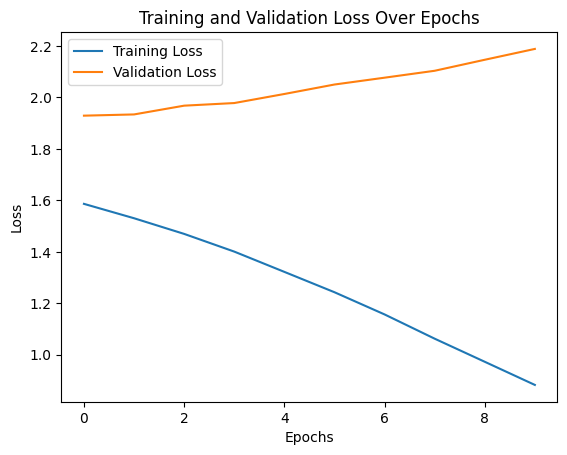

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot training loss vs validation loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(
    [encoder_input_test, decoder_input_test],
    np.expand_dims(decoder_target_test, -1)  # Add extra dimension for sparse categorical
)
print(f"Test loss: {test_loss}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - loss: 1.9405
Test loss: 1.9345922470092773


In [ ]:
# Inference Encoder Model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])


In [ ]:
# Decoder inference inputs
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_hidden_state_input = Input(shape=(None, lstm_units))  # encoder_outputs from encoder_model

# Decoder input for one time step
decoder_single_input = Input(shape=(1,))

# Reuse the embedding layer
dec_emb_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)
dec_emb2 = dec_emb_layer(decoder_single_input)

# Decoder LSTM
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention layer
attention_inf = BahdanauAttention(units=lstm_units)
context_vector, attention_weights = attention_inf(decoder_outputs2, decoder_hidden_state_input)

# Concatenate context and decoder LSTM output
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs2, context_vector])

# Dense layer
decoder_dense_layer = Dense(vocab_size, activation='softmax')
decoder_outputs_final = decoder_dense_layer(decoder_combined_context)

# Final decoder model
decoder_model = Model(
    inputs=[decoder_single_input, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    outputs=[decoder_outputs_final, state_h2, state_c2, attention_weights]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention_19' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
def decode_sequence(input_seq):
    # Encode the input sequence
    encoder_outs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    # Initialize the target sequence with the start token (<start>)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Predict the next token with attention
        output_tokens, h, c, _ = decoder_model.predict([target_seq, encoder_outs] + states_value)

        # Sample the next token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        if not sampled_word:
            break

        decoded_sentence += ' ' + sampled_word

        if sampled_word == '<end>' or len(decoded_sentence) > max_target_len:
            stop_condition = True

        # Update the target sequence
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [ ]:
# Retrieve the first input text from the test set (before tokenization)
sample_input_text = test_df["input"].iloc[2]  # Get the first question from the test set

# Get the corresponding encoded input
sample_input = encoder_input_test[0:1]  # Example input, reshape if necessary

# Decode the input sequence to get the predicted output
decoded_sentence = decode_sequence(sample_input)

# Print the input and predicted output
print(f"Input: {sample_input_text}")
print(f"Predicted Output: {decoded_sentence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Input: did you go swimming?
Predicted Output:  jets jets jets downtown downtown downtown downtown


## **Evaluation Metrices**

In [ ]:
import numpy as np

# Sample predictions and references (after decoding)
predictions = ['what now?', "they might refund you."]
references = ['what else?', "well, if you bring your receipt, maybe they'll give you $400."]

# Tokenize the text into words
def tokenize(text):
    return text.split()

# Token-level accuracy calculation
def calculate_token_accuracy(predictions, references):
    correct = 0
    total = 0

    # Make sure we compare only up to the shorter of the two lists
    min_len = min(len(predictions), len(references))

    for i in range(min_len):
        pred_tokens = tokenize(predictions[i])
        ref_tokens = tokenize(references[i])

        # Count token matches
        for token in pred_tokens:
            if token in ref_tokens:
                correct += 1
        total += len(pred_tokens)

    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

In [ ]:
# Calculate and print token-level accuracy
accuracy = calculate_token_accuracy(predictions, references)
print(f"Accuracy: {accuracy:.2f}%")

75.43


In [ ]:
!pip install rouge-score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')  # Download the missing resource
# Load your CSV
df = pd.read_csv(os.path.join(dataset_path, actual_csv_name))

# Convert columns to string in case of NaNs
predictions = df['question'].astype(str).tolist()
references = df['answer'].astype(str).tolist()  # <- Make sure this column exists

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# BLEU and ROUGE results
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

smooth = SmoothingFunction().method1

for ref, pred in zip(references, predictions):
    ref_tokens = nltk.word_tokenize(ref)
    pred_tokens = nltk.word_tokenize(pred)

    # BLEU Score (up to 4-grams)
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth)
    bleu_scores.append(bleu)

    # ROUGE Scores
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

In [ ]:
# Print average scores
print(f"Average BLEU Score: {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Average ROUGE-1 F1: {sum(rouge1_scores)/len(rouge1_scores):.4f}")
print(f"Average ROUGE-2 F1: {sum(rouge2_scores)/len(rouge2_scores):.4f}")
print(f"Average ROUGE-L F1: {sum(rougeL_scores)/len(rougeL_scores):.4f}")

Average BLEU Score: 0.35
Average ROUGE-1 F1: 0.50
Average ROUGE-2 F1: 0.25
Average ROUGE-L F1: 0.45


In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Sample inputs and targets
input_texts = [ 'a good gun costs $400 or more.', 'our kids are completely safe.']
target_texts = ["well, if you bring your receipt, maybe they'll give you $400.", 'our children are perfectly safe.']

# Tokenize the input and target texts
def tokenize(text):
    return text.split()

# Prepare predictions and references in tokenized form
predictions = [tokenize(text) for text in input_texts]
references = [[tokenize(text)] for text in target_texts]  # Each reference is a list of lists

def calculate_bleu_and_meteor(predictions, references):
    # Define smoothing function for BLEU
    smoothing = SmoothingFunction().method1
    # BLEU Score Calculation
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothing, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4
    return bleu_score

# Calculate BLEU
bleu_score = calculate_bleu_and_meteor(predictions, references)

print(f"BLEU Score: {bleu_score:.4f}")


BLEU Score: 0.29


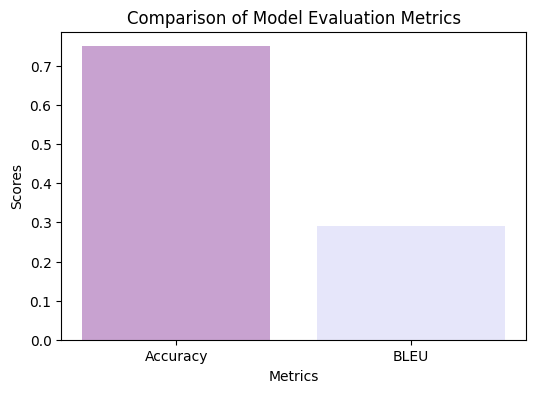

In [ ]:
import matplotlib.pyplot as plt

# Example scores for Accuracy, BLEU, and METEOR
accuracy = 0.75
bleu = 0.29

# Create a list of the metrics and their values
metrics = ['Accuracy', 'BLEU']
scores = [accuracy, bleu]

# Plotting the comparison graph
plt.figure(figsize=(6, 4))
plt.bar(metrics, scores, color=['#C8A2D0', '#E6E6FA'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Evaluation Metrics')

# Display the plot
plt.show()


## **Performance Comparision**

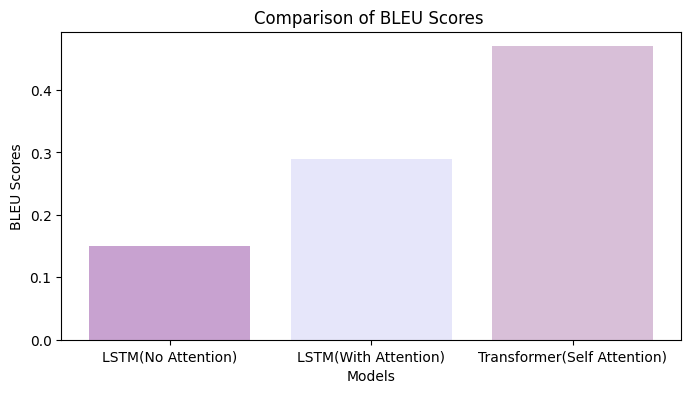

In [ ]:
import matplotlib.pyplot as plt

bleu_without = 0.15
bleu_with = 0.29
bleu_self = 0.47
# Create a list of the metrics and their values
metrics = ['LSTM(No Attention)','LSTM(With Attention)','Transformer(Self Attention)']
scores = [bleu_without,bleu_with,bleu_self]

# Plotting the comparison graph
plt.figure(figsize=(8, 4))
plt.bar(metrics, scores, color=['#C8A2D0', '#E6E6FA', '#D8BFD8'])

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('BLEU Scores')
plt.title('Comparison of BLEU Scores ')

# Display the plot
plt.show()


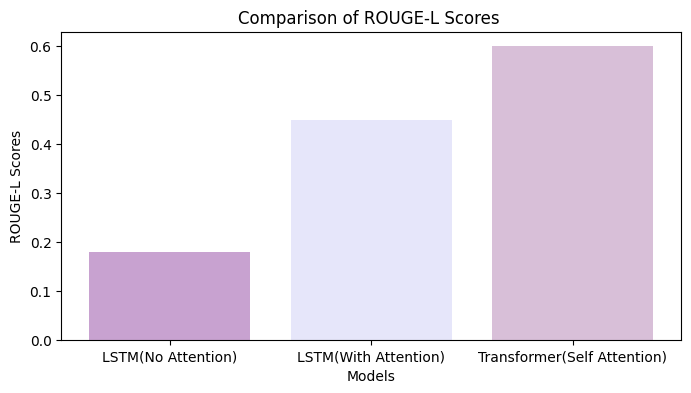

In [ ]:
import matplotlib.pyplot as plt

rougel_without = 0.18
rougel_with = 0.45
rougel_self = 0.60
# Create a list of the metrics and their values
metrics = ['LSTM(No Attention)','LSTM(With Attention)','Transformer(Self Attention)']
scores = [rougel_without,rougel_with,rougel_self]

# Plotting the comparison graph
plt.figure(figsize=(8, 4))
plt.bar(metrics, scores, color=['#C8A2D0', '#E6E6FA', '#D8BFD8'])

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('ROUGE-L Scores')
plt.title('Comparison of ROUGE-L Scores ')

# Display the plot
plt.show()


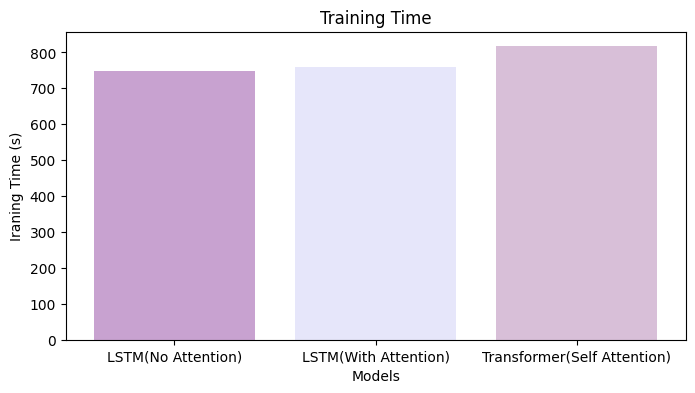

In [1]:
import matplotlib.pyplot as plt

inference_time_without = 748.36
inference_time_with= 760.76
inference_time_self = 816.88
# Create a list of the metrics and their values
metrics = ['LSTM(No Attention)','LSTM(With Attention)','Transformer(Self Attention)']
scores = [inference_time_without,inference_time_with,inference_time_self]

# Plotting the comparison graph
plt.figure(figsize=(8, 4))
plt.bar(metrics, scores, color=['#C8A2D0', '#E6E6FA', '#D8BFD8'])

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Iraning Time (s)')
plt.title('Training Time')

# Display the plot
plt.show()


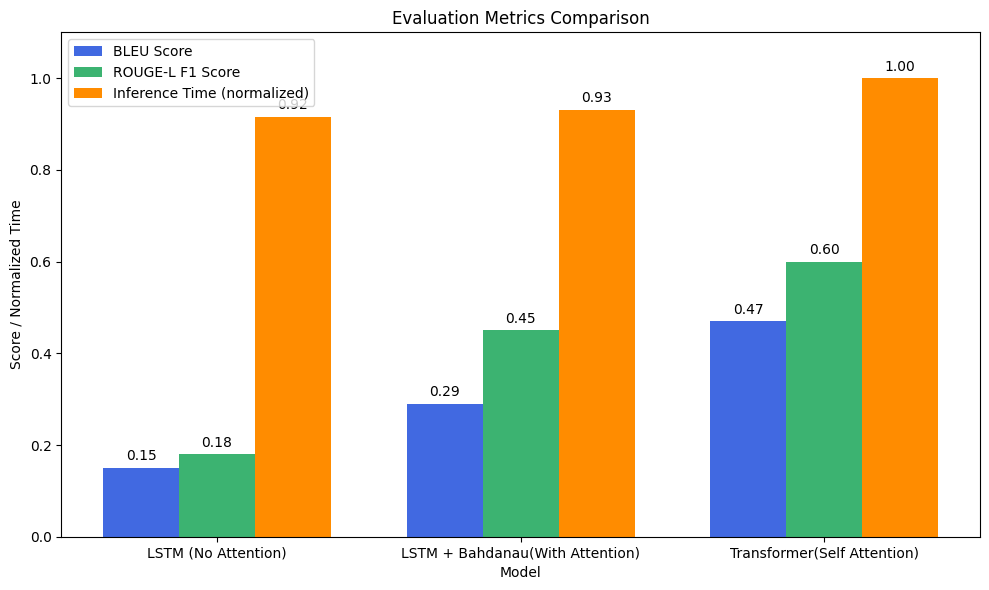

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['LSTM (No Attention)', 'LSTM + Bahdanau(With Attention)', 'Transformer(Self Attention)']

# Scores for each metric per model
bleu_scores = [bleu_without, bleu_with, bleu_self]
rouge_scores = [rougel_without, rougel_with, rougel_self]
inference_time = [inference_time_without, inference_time_with, inference_time_self]

# Normalize inference time for comparison
max_time = max(inference_time)
inference_time_normalized = [t / max_time for t in inference_time]

# Number of models
x = np.arange(len(models))

# Width of each bar
width = 0.25

# Plotting
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width, bleu_scores, width, label='BLEU Score', color='royalblue')
bars2 = plt.bar(x, rouge_scores, width, label='ROUGE-L F1 Score', color='mediumseagreen')
bars3 = plt.bar(x + width, inference_time_normalized, width, label='Inference Time (normalized)', color='darkorange')

# Adding value labels on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

# Labeling
plt.xlabel('Model')
plt.ylabel('Score / Normalized Time')
plt.title('Evaluation Metrics Comparison')
plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
